In [1]:
%load_ext tensorboard

In [2]:
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import datetime
from tensorboard.plugins.hparams import api as hp

data=pd.read_excel('datos.xls')

X = data.iloc[:,:31]
X=X.values
y =data.iloc[:,32]
y=y.values

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
SimpleImputer()
X = imp.transform(X)

X_normalized = preprocessing.normalize(X, norm='l2')

train_data, test_data, train_targets, test_targets = train_test_split(X_normalized, y, test_size=0.1)

def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(32, name='Dense_1', kernel_regularizer=regularizers.l2(wd), 
              kernel_initializer='he_uniform', bias_initializer='ones',
              activation="relu", input_shape=(train_data.shape[1],)),
        
        #BatchNormalization(name='Norm_1'),  # <- Batch normalisation layer
        #Dropout(rate, name='Drop_1'),
        #BatchNormalization(name='Norm_2'),  # <- Batch normalisation layer
    
        Dense(128/2, name='Dense_2', kernel_regularizer=regularizers.l2(wd), activation="relu"),
        #Dropout(rate, name='Drop_2'),
        Dense(2,  name='Softmax', activation='softmax')
    ])
    return model 

model = get_regularised_model(1e-5, 0.1)
model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse','accuracy'])


log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#history = model.fit(train_data, train_targets, epochs=100, 
#                    validation_split=0.15, batch_size=64, verbose=2)

model.fit(x=train_data, 
          y=train_targets, 
          epochs=10, 
          batch_size=8,
          validation_split=0.15, 
          callbacks=[tensorboard_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 32)                1024      
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
Softmax (Dense)              (None, 2)                 130       
Total params: 3,266
Trainable params: 3,266
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 1s 189ms/step - loss: 0.2552 - mse: 0.2541 - accuracy: 0.4997 - val_loss: 0.2520 - val_mse: 0.2509 - val_accuracy: 0.2857
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.2521 - mse: 0.2510 - accuracy: 0.3507 - val_loss: 0.2522 - val_mse: 0.2511 - val_accuracy: 0.7143
Epoch 3/10
5/5 [=========================

In [9]:
%tensorboard --logdir=logs2/fit

Reusing TensorBoard on port 6006 (pid 17192), started 0:04:22 ago. (Use '!kill 17192' to kill it.)

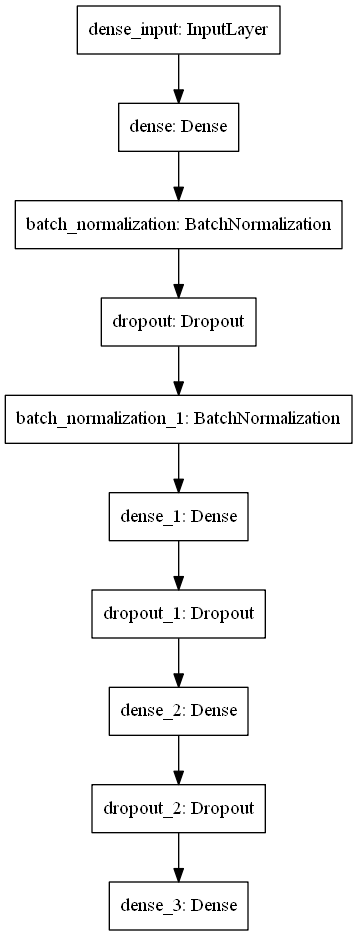

In [5]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)